In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [3]:
files = 'gs://hm-eu-w4/jigsaw/s07/*/params0.9*.csv'
candidates = sorted(tf.io.gfile.glob(files))

print(len(candidates))
candidates

16


['gs://hm-eu-w4/jigsaw/s07/20200513_221920_t8b/params0.961557.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b/params0.962582.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_032013_t8b/params0.960277.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_061900_t8b/params0.961239.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_084910_t8d/params0.960903.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_121459_t8c/params0.961004.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_133640_t8b/params0.961496.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_161142_t8d/params0.960749.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/params0.961606.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200514_221007_t8b/params0.961549.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200515_022827_t8b/params0.960675.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200515_055220_t2c/params0.961303.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200515_090020_t2b/params0.960323.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200515_095153_t2c/params0.961547.csv',
 'gs://hm-eu-w4/jigsaw/s07/20200515_124328_t2b/p

In [13]:
!gsutil ls gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d	

gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/best_model.tf.data-00000-of-00002
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/best_model.tf.data-00001-of-00002
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/best_model.tf.index
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/checkpoint
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/history.csv
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/history.png
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/params0.961606.csv
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/sub_hist.png
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/submission.csv
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/valid_hist.png
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/valid_oof.csv
gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/valid_toxic_hist.png


In [18]:
pd.read_csv('gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d/params0.961606.csv').T[0]

dual                                                            False
tpu_id                                                            t8d
batch_size                                                         24
max_len                                                           192
seed                                                              418
path                                                       jigsaw/s07
gcs                                                          hm-eu-w4
dataset             gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...
pooling                                                           GeM
optimizer                                                        LAMB
lr                                                        8.41074e-05
mom_min                                                      0.915452
mom_max                                                      0.950119
div_factor                                                    214.501
final_div_factor    

In [5]:
df = None

for f in candidates:
    score = float(os.path.basename(f)[6:-4])
    if score > 0.94:
        if df is None:
            df = pd.read_csv(f)
        else:
            df = df.append(pd.read_csv(f), ignore_index=True)

df.describe()

,auc,batch_size,div_factor,dropout,epochs,final_div_factor,gamma,label_smoothing,lr,max_len,mom_max,mom_min,pos_weight,seed,warm_up,weight_decay
count,16.000000,16.0,16.000000,16.000000,16.000000,16.000000,9.000000,16.000000,16.000000,16.0,16.000000,16.000000,9.000000,16.00000,16.000000,1.600000e+01
mean,0.961099,24.0,183.090911,0.187500,41.812500,1792.957073,1.440082,0.018611,0.000042,192.0,0.932085,0.864438,2.970671,527.62500,2.873869,7.788908e-06
std,0.000629,0.0,204.811265,0.124499,3.885336,2656.922454,0.653477,0.014126,0.000023,0.0,0.023429,0.035062,0.972453,277.23561,1.202638,1.191064e-05
min,0.960277,24.0,11.210735,0.000000,33.000000,11.378653,0.780659,0.002591,0.000011,192.0,0.901699,0.804073,1.692145,56.00000,1.033731,1.452406e-07
25%,0.960619,24.0,39.771084,0.100000,39.000000,96.484468,0.935811,0.007508,0.000025,192.0,0.905722,0.836088,2.202724,338.00000,1.940789,1.995352e-06
50%,0.961122,24.0,83.961210,0.150000,41.500000,430.620807,1.107284,0.011544,0.000033,192.0,0.933025,0.865026,2.939890,519.50000,2.994345,4.356102e-06
75%,0.961547,24.0,237.407709,0.250000,43.250000,2008.788366,1.793351,0.029473,0.000053,192.0,0.950049,0.890704,3.297942,715.00000,3.724873,7.830425e-06
max,0.962582,24.0,657.117150,0.450000,48.000000,7487.892232,2.443165,0.045447,0.000084,192.0,0.966027,0.915452,5.032641,939.00000,4.557490,4.947277e-05


In [6]:
# df.groupby('loss').loss.count().to_frame('loss')
df.pooling.fillna('first', inplace=True)
df.groupby('pooling').auc.describe()

,count,mean,std,min,25%,50%,75%,max
pooling,,,,,,,,
GeM,7.0,0.961126,0.000503,0.960277,0.960826,0.961239,0.961553,0.961606
first,6.0,0.961138,0.000847,0.960323,0.960508,0.960989,0.961448,0.962582
max,3.0,0.960956,0.000616,0.960318,0.960661,0.961004,0.961275,0.961547


In [7]:
df.drop(['max_len', 'gcs',
         'path', 'tpu_id', 'seed', 'dataset'], #'model_id', 'stages', 'amp', , 'callback', 'kwargs'
              inplace=True, axis=1)
df.sort_values(by='auc', ascending=False)

,auc,batch_size,div_factor,dropout,dual,epochs,final_div_factor,gamma,gcs_path,label_smoothing,loss_fn,lr,model_id,mom_max,mom_min,optimizer,pooling,pos_weight,warm_up,weight_decay
1,0.962582,24,74.138260,0.25,False,40,2269.157070,0.990529,gs://hm-eu-w4/jigsaw/s07/20200514_004651_t8b,0.009820,focal,0.000050,NaN,0.934460,0.836987,LAMB,first,2.165151,3.539545,6.719302e-06
8,0.961606,24,214.501461,0.20,False,33,109.549947,1.640897,gs://hm-eu-w4/jigsaw/s07/20200514_182357_t8d,0.040482,focal,0.000084,NaN,0.950119,0.915452,LAMB,GeM,1.692145,4.509284,4.269837e-06
0,0.961557,24,204.755795,0.05,False,39,7487.892232,NaN,gs://hm-eu-w4/jigsaw/s07/20200513_221920_t8b,0.007568,bce,0.000025,NaN,0.962060,0.893677,AdamW,GeM,NaN,3.579122,1.452406e-07
9,0.961549,24,64.078509,0.30,False,43,1921.998798,2.443165,gs://hm-eu-w4/jigsaw/s07/20200514_221007_t8b,0.007325,focal,0.000083,NaN,0.901699,0.847425,LAMB,GeM,2.939890,1.387996,4.442366e-06
13,0.961547,24,43.372146,0.25,False,47,146.376781,NaN,gs://hm-eu-w4/jigsaw/s07/20200515_095153_t2c,0.028743,bce,0.000020,NaN,0.950026,0.877638,AdamW,max,NaN,2.873741,5.052141e-07
6,0.961496,24,21.342047,0.40,False,44,1048.616010,0.935811,gs://hm-eu-w4/jigsaw/s07/20200514_133640_t8b,0.031665,focal,0.000063,NaN,0.946076,0.876695,LAMB,first,3.159604,2.370859,1.298163e-05
11,0.961303,24,28.967900,0.15,False,48,5756.370000,NaN,gs://hm-eu-w4/jigsaw/s07/20200515_055220_t2c,0.045447,bce,0.000031,jplu/tf-xlm-roberta-large,0.901919,0.827043,LAMB,first,NaN,4.557490,1.329220e-05
3,0.961239,24,657.117150,0.15,False,39,30.406556,NaN,gs://hm-eu-w4/jigsaw/s07/20200514_061900_t8b,0.005238,bce,0.000044,NaN,0.903347,0.905457,LAMB,GeM,NaN,2.063148,2.492064e-06
5,0.961004,24,11.210735,0.25,False,42,26.797113,0.870530,gs://hm-eu-w4/jigsaw/s07/20200514_121459_t8c,0.002591,focal,0.000050,NaN,0.931590,0.849755,LAMB,max,2.769252,1.573711,2.154377e-07
4,0.960903,24,435.654038,0.00,False,39,11.378653,2.398512,gs://hm-eu-w4/jigsaw/s07/20200514_084910_t8d,0.032881,focal,0.000034,NaN,0.949034,0.804073,AdamW,GeM,3.297942,3.469336,1.116379e-05


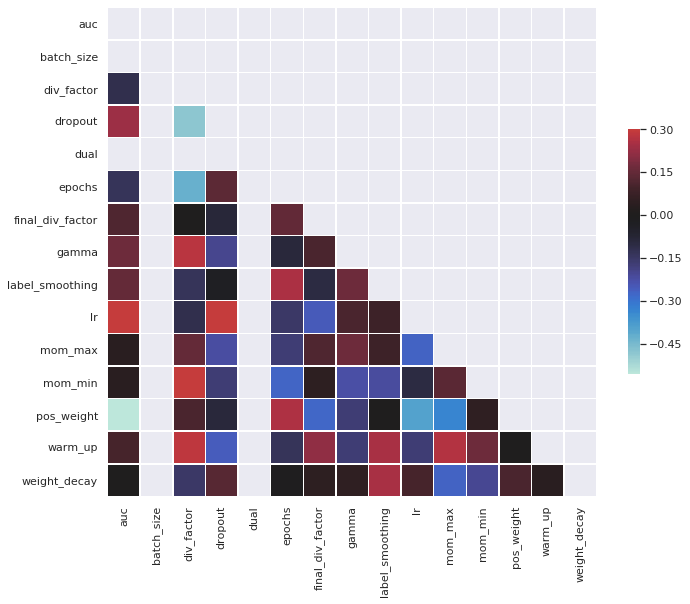

In [8]:
# Compute the correlation matrix
corr = df.corr('kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, vmax=.3, center=0, # cmap=cmap,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
files, preds, oof, scores = [], [], [], []

for f in candidates:
    score = float(os.path.basename(f)[6:-4])
    if score < 0.955:
        continue
    folder = os.path.dirname(f)
    sub_path = os.path.join(folder, 'submission.csv')
    sub = pd.read_csv(sub_path)
    print(score, sub.toxic.mean(), (sub.toxic > 0.5).mean(), sub_path)
    if sub.toxic.mean() < 0.49:
        files.append(f)
        scores.append(score)

        sub.to_csv(f'../submission_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        preds.append(sub.toxic.values)

        valid = pd.read_csv(os.path.join(folder, 'valid_oof.csv'))
        valid.to_csv(f'../valid_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        oof.append(valid.pred.values)
        assert abs(roc_auc_score(valid.toxic, valid.pred) - score) < 1e-5

        params = pd.read_csv(f)
        params.to_csv(f'../params_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)

# !ls -sh ../submission_*.csv

0.955511 0.3622144613480223 0.2539020873816837 gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/submission.csv
0.955327 0.44813851293502793 0.2800727135961888 gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/submission.csv
0.955442 0.34682769331669594 0.2254278192189557 gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/submission.csv
0.955724 0.2313057937686015 0.2110104682504858 gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/submission.csv
0.956338 0.23457636069512788 0.21629160659437097 gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/submission.csv
0.956769 0.22726137278612174 0.2301761424183539 gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/submission.csv
0.956153 0.41266451836175017 0.24741427944587224 gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/submission.csv
0.956442 0.3539857048345296 0.2475396477151633 gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/submission.csv
0.955524 0.437688493327744 0.307152259763054 gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/submission.csv


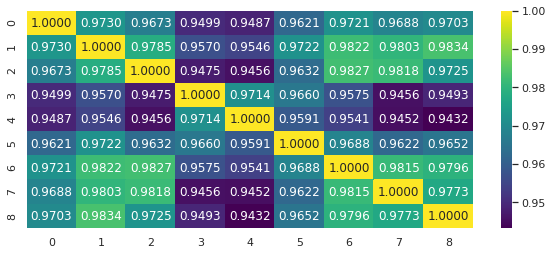

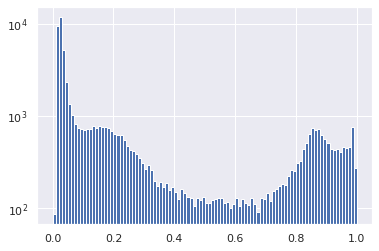

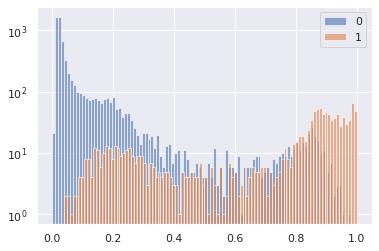

AUC: 0.9574942056658381 toxic: 0.15375 pred: 0.20297790759326625 ratio: 0.16525
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.11419054604954515,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.08681098616425555,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.10350189276649674,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.14112476658716738,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.14997696366364352,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.11158311867745392,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.08786958844085206,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.10210744551306085,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.10283469213752484}

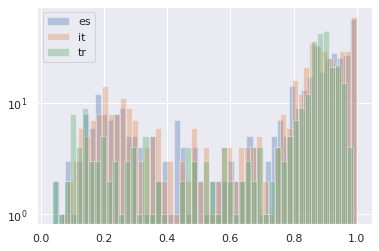

In [40]:
corr_mat = np.corrcoef(preds)
# print(corr_mat)

weights = (1-corr_mat).sum(axis=0) # gain
weights /= weights.sum()

fig, ax = plt.subplots(figsize=(len(preds)+1, len(preds)//2))
ax = sns.heatmap(corr_mat, cmap='viridis', annot=True, fmt="0.04f", ax=ax)
plt.show()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
valid['pred'] = np.average(oof, weights=weights, axis=0)
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

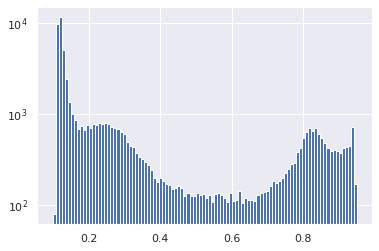

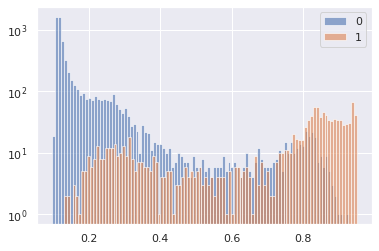

AUC: 0.9575158218347323 toxic: 0.15375 pred: 0.2701708645138708 ratio: 0.168375
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.11008982335267752,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.10963638329947113,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.10991934447545383,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.1106194360632684,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.11217502980022154,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.11329338093352613,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.11170173902746537,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.11244286126859065,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.11012200177932537}

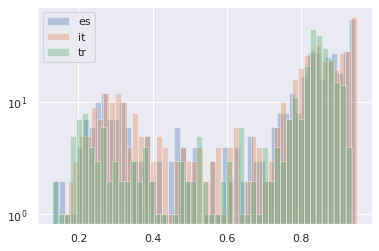

In [41]:
# weight by score
weights = 1 / (1-np.array(scores))
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

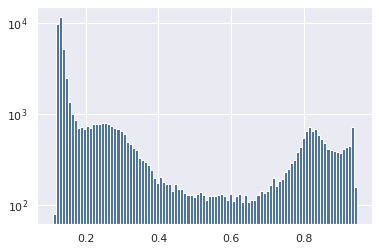

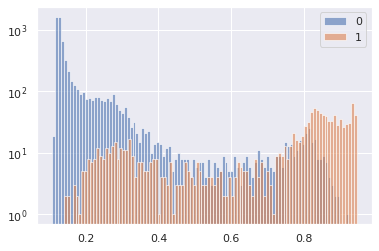

AUC: 0.9575066950078658 toxic: 0.15375 pred: 0.27803080351527726 ratio: 0.16925
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.1111111111111111}

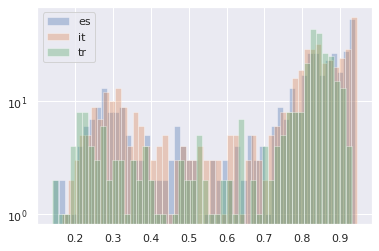

In [42]:
# average
weights = np.ones_like(scores)
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

shapes: (8000, 10) (8000,)
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         2.5782e+04                                    7.30e+03    
       1         5.9991e+03      1.98e+04       1.10e+00       1.82e+03    
       2         1.4246e+03      4.57e+03       5.45e-01       4.49e+02    
       3         4.5777e+02      9.67e+02       2.64e-01       1.11e+02    
       4         2.8813e+02      1.70e+02       1.15e-01       2.76e+01    
       5         2.5810e+02      3.00e+01       7.39e-02       1.23e+01    
       6         2.4412e+02      1.40e+01       2.16e-01       2.18e+00    
       7         2.4082e+02      3.30e+00       1.71e-01       4.06e-01    
       8         2.3999e+02      8.27e-01       6.81e-02       8.21e-02    
       9         2.3970e+02      2.94e-01       2.55e-02       1.64e-01    
      10         2.3967e+02      3.29e-02       5.48e-03       2.05e-03    
      11         2.3967e+02      1.12e-04       3.65e-05     

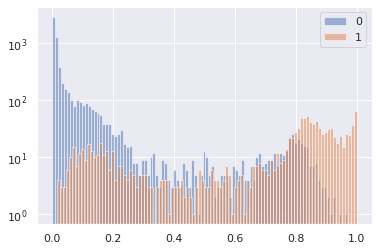

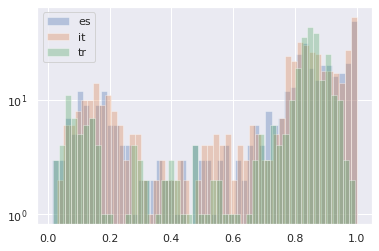

AUC: 0.9574263549134754 toxic: 0.15375 pred: 0.17421199825706565 ratio: 0.16275
mean score: 0.9559144444444444
top score: 0.956769 5 0.9567685028401245
0.3849490227993062
0


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 4.408574013323907e-34,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 3.28178462523585e-31,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 5.506542445410801e-41,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.21501630306892977,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.05419156223222812,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.5839400942708689,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 4.653046745639562e-31,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.058664949722203964,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 1.6601516120617973e-31}

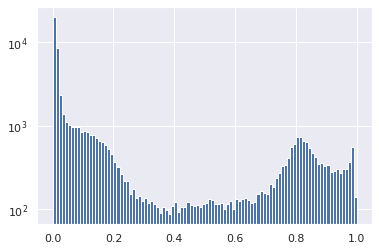

In [43]:
from scipy.optimize import lsq_linear

bias = np.ones_like(oof[0]).tolist()
A = np.stack(oof + [bias]).T.copy()
# A = np.stack(oof).T.copy()
b = valid.toxic.values.copy()
print('shapes:', A.shape, b.shape)

res = lsq_linear(A, b, bounds=(0, 1), lsq_solver='exact', method='trf', tol=1e-15, verbose=2)
print(res)
best_weights = res.x
valid_preds = A.dot(best_weights)
print('MSE:', mean_squared_error(b, valid_preds))
print('AUC:', roc_auc_score(b, valid_preds))
print('Sum of weights:', sum(best_weights))

valid['pred'] = valid_preds
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())
plt.show()

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))
top = np.argmax(best_weights[:len(preds)])
print('top score:', scores[top], top, roc_auc_score(valid.toxic, oof[top]))

sub['toxic'] = np.stack(preds).T.dot(best_weights[:len(preds)])
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
ax = sub.toxic.hist(bins=100, log=True)
sub.to_csv(f'../submission_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)

bias = np.ones_like(oof[0]).tolist()
print(abs(A - np.stack(oof + [bias]).T.copy()).max())
# print(abs(A - np.stack(oof).T.copy()).mean())
print(abs(b - valid.toxic.values.copy()).max())

{f:w for f,w in zip(files, best_weights[:len(preds)])}

# Remove low scoring and incomplete models 

In [38]:
import tensorflow as tf
import pandas as pd

# clean up
folders = 'gs://hm-eu-w4/jigsaw/*/*/*'
models = []
for f in tf.io.gfile.glob(folders):
    n_items = len(tf.io.gfile.glob(os.path.join(f, 'best_model.tf*')))
    if n_items > 0:
        params = tf.io.gfile.glob(os.path.join(f, 'params*.csv'))
        if len(params) == 0:
            print(f, n_items, tf.io.gfile.glob(os.path.join(f, '*')))
            !gsutil -m rm -r {f}
        else:
            score = float(os.path.basename(params[0])[6:-4])
            print(f, n_items, len(tf.io.gfile.glob(os.path.join(f, '*'))), score)
            if score < 0.955:
                !gsutil -m rm -r {f}
            else:
                models.append(f.split('/')[-3:-1] + [score])
#     elif n_items == 0:
#         !gsutil rm -r {f}

gs://hm-eu-w4/jigsaw/bt05/20200506_194600_t8d/ 3 12 0.95527
gs://hm-eu-w4/jigsaw/bt05/20200506_215624_t8b/ 3 12 0.955373
gs://hm-eu-w4/jigsaw/bt05/20200507_160433_t8d/ 3 12 0.955986
gs://hm-eu-w4/jigsaw/bt05/20200508_214456_t8b/ 3 12 0.955258
gs://hm-eu-w4/jigsaw/bt05/20200509_101452_t8d/ 3 12 0.956088
gs://hm-eu-w4/jigsaw/bt05/20200509_122405_t8d/ 3 12 0.955531
gs://hm-eu-w4/jigsaw/bt05/20200509_212548_t8d/ 3 12 0.955396
gs://hm-eu-w4/jigsaw/bt05/20200509_230445_t8d/ 3 12 0.955231
gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/ 3 12 0.961078
gs://hm-eu-w4/jigsaw/s06/20200512_081548_t8b/ 3 12 0.959556
gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/ 3 12 0.959827
gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/ 3 12 0.959633
gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/ 3 12 0.959691
gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/ 3 12 0.959693
gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/ 3 12 0.960449
gs://hm-eu-w4/jigsaw/s06/20200512_211728_t8b/ 3 12 0.960184
gs://hm-eu-w4/jigsaw/s06/20200512

In [39]:
df = pd.DataFrame(models, columns=['type', 'id', 'auc'])
df.groupby('type').describe()

auc                                                              \
     count      mean       std       min       25%       50%       75%   
type                                                                     
bt05   8.0  0.955517  0.000336  0.955231  0.955267  0.955385  0.955645   
s06   13.0  0.960019  0.000463  0.959556  0.959691  0.959827  0.960184   
s07   16.0  0.961099  0.000630  0.960277  0.960619  0.961121  0.961547   
s08    9.0  0.955914  0.000520  0.955327  0.955511  0.955724  0.956338   
t03    1.0  0.957579       NaN  0.957579  0.957579  0.957579  0.957579   
t04    4.0  0.960909  0.000846  0.959791  0.960608  0.961009  0.961310   
t05   14.0  0.960762  0.000679  0.959954  0.960227  0.960592  0.961206   
t12    9.0  0.960647  0.000625  0.960124  0.960299  0.960400  0.960744   

                
           max  
type            
bt05  0.956088  
s06   0.961078  
s07   0.962582  
s08   0.956769  
t03   0.957579  
t04   0.961828  
t05   0.961848  
t12   0.962192

In [49]:
# import pdb; pdb.pm()